# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import datetime
import random
import os

%load_ext tensorboard

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Data

In [3]:
data_path = 'https://raw.githubusercontent.com/antbartash/max_temp/master/data/data_features.csv'
data = pd.read_csv(data_path)
data['DATE'] = data['DATE'].astype('datetime64[ns]')

print(data.shape)
data.head()

(40778, 54)


,DATE,TARGET,TMAX_d1,TMAX_d1_d2_diff,TMAX_3day_mean,TMAX_3day_std,TMAX_3day_min,TMAX_3day_max,TMAX_3day_median,TMAX_5day_mean,...,MONTH_11,MONTH_12,STATION_USW00003967,STATION_USW00012916,STATION_USW00013960,STATION_USW00024025,STATION_USW00024233,STATION_USW00093067,STATION_USW00093225,STATION_USW00094728
0,2010-01-16,15.6,15.0,-1.1,13.700000,3.251154,10.0,16.1,15.0,12.98,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-17,14.4,15.6,0.6,15.566667,0.550757,15.0,16.1,15.6,14.22,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-18,17.2,14.4,-1.2,15.000000,0.600000,14.4,15.6,15.0,14.22,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-19,21.1,17.2,2.8,15.733333,1.404754,14.4,17.2,15.6,15.66,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-20,23.9,21.1,3.9,17.566667,3.365016,14.4,21.1,17.2,16.66,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X_train = data.loc[data['DATE'].dt.year <= 2021].drop(columns=['TARGET', 'DATE']).copy()
y_train = data.loc[data['DATE'].dt.year <= 2021, 'TARGET'].copy()
X_valid = data.loc[data['DATE'].dt.year == 2022].drop(columns=['TARGET', 'DATE']).copy()
y_valid = data.loc[data['DATE'].dt.year == 2022, 'TARGET'].copy()
X_test = data.loc[data['DATE'].dt.year == 2023].drop(columns=['TARGET', 'DATE']).copy()
y_test = data.loc[data['DATE'].dt.year == 2023, 'TARGET'].copy()

print(f'Train: {X_train.shape}, {y_train.shape}')
print(f'Valid: {X_valid.shape}, {y_valid.shape}')
print(f'Test: {X_test.shape}, {y_test.shape}')

Train: (34938, 52), (34938,)
Valid: (2920, 52), (2920,)
Test: (2920, 52), (2920,)


In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=scaler.feature_names_in_)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=scaler.feature_names_in_)
X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.feature_names_in_)

print(f'Train: {X_train.shape}, {y_train.shape}')
print(f'Valid: {X_valid.shape}, {y_valid.shape}')
print(f'Test: {X_test.shape}, {y_test.shape}')

Train: (34938, 52), (34938,)
Valid: (2920, 52), (2920,)
Test: (2920, 52), (2920,)


In [6]:
BATCH_SIZE = 64
PREFETCH = 1
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(PREFETCH)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(BATCH_SIZE).prefetch(PREFETCH)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(PREFETCH)

# Baseline

In [7]:
# tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=100, restore_best_weights=True
)

# lr scheduler
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=25
)

## Optimizing w.r.t MSE

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,
              metrics=['mean_absolute_error'])

history = model.fit(train_dataset, epochs=1000, validation_data=valid_dataset,
                    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback])

Epoch 1/1000
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 249.5010 - mean_absolute_error: 13.2331 - val_loss: 81.8077 - val_mean_absolute_error: 7.0756 - learning_rate: 0.0010
Epoch 2/1000
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 38.6484 - mean_absolute_error: 4.7025 - val_loss: 44.5221 - val_mean_absolute_error: 5.2717 - learning_rate: 0.0010
Epoch 3/1000
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.3669 - mean_absolute_error: 3.7054 - val_loss: 25.7079 - val_mean_absolute_error: 3.9510 - learning_rate: 0.0010
Epoch 4/1000
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16.4200 - mean_absolute_error: 3.0860 - val_loss: 21.7331 - val_mean_absolute_error: 3.5747 - learning_rate: 0.0010
Epoch 5/1000
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.5034 - mean_absolute_error: 2.8521 - val_loss: 20.6770 - val_mean_absolute_error: 3.4385 - learning_rate: 0.0010
Epoch 6/1000
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.9433 - mean_absolute_error: 2.7765 - val_lo

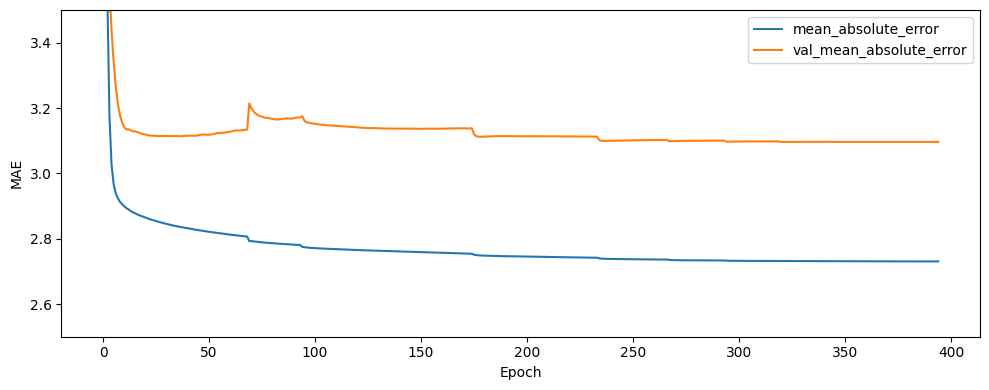

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
ax.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
ax.set_ylim(2.5, 3.5)
ax.set_ylabel('MAE')
ax.set_xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(train_dataset))}')
print(f'Valid MAE: {mean_absolute_error(y_valid, model.predict(valid_dataset))}')

546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Train MAE: 2.7319127727282657
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Valid MAE: 3.0967000042289903


## Optimizing w.r.t. MAE

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer,
              metrics=['mean_squared_error'])

history2 = model.fit(train_dataset, epochs=1000, validation_data=valid_dataset,
                     callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback])

Epoch 1/1000
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.8180 - mean_squared_error: 242.3622 - val_loss: 7.3407 - val_mean_squared_error: 86.9756 - learning_rate: 0.0010
Epoch 2/1000
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4400 - mean_squared_error: 36.7141 - val_loss: 5.0164 - val_mean_squared_error: 40.2229 - learning_rate: 0.0010
Epoch 3/1000
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2619 - mean_squared_error: 18.9535 - val_loss: 3.7277 - val_mean_squared_error: 24.2512 - learning_rate: 0.0010
Epoch 4/1000
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8566 - mean_squared_error: 15.0635 - val_loss: 3.3156 - val_mean_squared_error: 20.4714 - learning_rate: 0.0010
Epoch 5/1000
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7398 - mean_squared_error: 14.2651 - val_loss: 3.2620 - val_mean_squared_error: 19.9814 - learning_rate: 0.0010
Epoch 6/1000
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7165 - mean_squared_error: 14.0829 - val_loss: 3.2627 

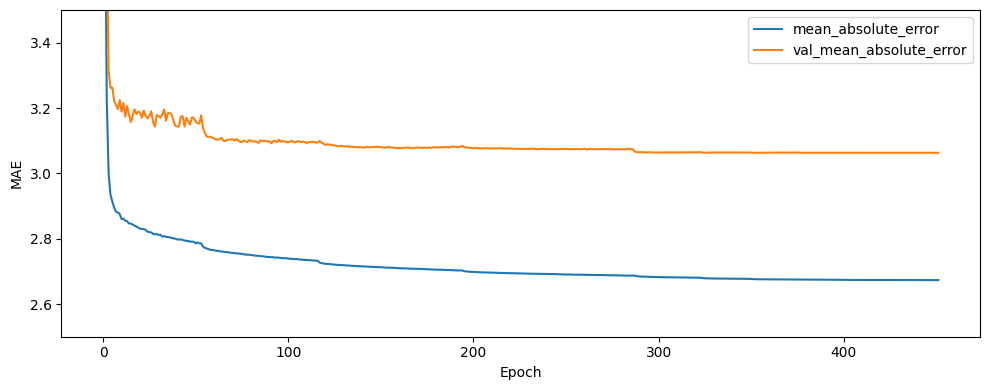

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history2.history['loss'], label='mean_absolute_error')
ax.plot(history2.history['val_loss'], label='val_mean_absolute_error')
ax.set_ylim(2.5, 3.5)
ax.set_ylabel('MAE')
ax.set_xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(train_dataset))}')
print(f'Valid MAE: {mean_absolute_error(y_valid, model.predict(valid_dataset))}')

546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Train MAE: 2.6753175073513713
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Valid MAE: 3.062835658915239
